In [90]:
# Importings base libraries
import os;
import pandas as pd; 
import numpy as np;
import librosa;
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline

# Models
import sklearn.model_selection # train_test_split
import sklearn.discriminant_analysis # LinearDiscriminantAnalysis
import sklearn.naive_bayes  # GaussianNB

seed = 42

In [2]:
# Working with data - Those functions are helpers to work with the final DataFrame

def get_audio_and_sampling_rate_from_df(df, row_index, asNumpyArray = True ):
    data, sampling_rate, label = get_data_sample_rate_and_legend_from_df(df, row_index, asNumpyArray)
    return(data, sampling_rate)

def get_data_sampling_rate_and_legend_from_df(df, row_index, asNumpyArray = True):
    data = df.iloc[ row_index , df.columns.get_loc(0): ].astype('float64')
    if(asNumpyArray):
        data = data.values
    sample_rate = df.loc[: , "sr"].iloc[row_index]
    label = df.loc[ : , 'label'].iloc[row_index]
    return(data, sample_rate, label)
    
def show_data(df, row):
    # Retrieve information from DF
    audio_data, sampling_rate, label = get_data_sample_rate_and_legend_from_df(df, row)
    
    # Print some stats and display the sound
    print(f"{label}({librosa.get_duration(audio_data, sr=sampling_rate)} sec)")
    ipd.display(ipd.Audio(audio_data, rate=sampling_rate))
    
    print("\n")
    # Make plots
    X = librosa.stft(audio_data)
    Xdb = librosa.amplitude_to_db(abs(X))

    plt.figure(figsize=(8, 16), dpi= 80, facecolor='w', edgecolor='k')

    plt.subplot(3, 1, 1)
    plt.title("Wave")
    librosa.display.waveplot(audio_data, sr=sampling_rate, x_axis="time")

    plt.subplot(3, 1, 2)
    plt.title("MEL")
    librosa.display.specshow(Xdb, sr=sampling_rate, x_axis="time", y_axis="mel")

    plt.subplot(3, 1, 3)
    plt.title("HZ")
    librosa.display.specshow(Xdb, sr=sampling_rate, x_axis="time", y_axis="hz")

    print("Audio")
    ipd.Audio(audio_data, rate = sampling_rate)

In [3]:
# Will read from the pickle file - use ingestion when ready
training_data_path   = os.path.join(".","dados","training_data.pickle")
validation_data_path = os.path.join(".","dados","validation_data.pickle")

In [4]:
# Will read only part of the data
training = pd.read_pickle(training_data_path).sample(1000, random_state = seed)

In [5]:
training.shape

(1000, 88204)

In [11]:
print(f"Shape: {training.shape} \n"+
      f"Número de Audios: {training.shape[0]} \n"+
      f"Número de Audios/4: {training.shape[0]/4}\n" +
      f"Numero De Arquivos Lidos: {len(training.original_file.unique())}\n"+
      f"Sample Rates: {training.sr.unique()}")


Shape: (1000, 88204) 
Número de Audios: 1000 
Número de Audios/4: 250.0
Numero De Arquivos Lidos: 352
Sample Rates: [44100]


In [7]:
training.head()

,label,duracao,sr,original_file,0,1,2,3,4,5,...,88190,88191,88192,88193,88194,88195,88196,88197,88198,88199
812,d,2.0,44100,ddam,-0.003235,-0.003296,-0.003326,-0.003296,-0.003143,-0.002930,...,-0.000290,-0.000244,-0.000610,-0.000336,-0.000275,-0.000336,-0.000031,-0.000549,-0.000671,-0.000046
916,m,2.0,44100,hacm,-0.000946,-0.001099,-0.000916,-0.000916,-0.001068,-0.000854,...,-0.000351,-0.000397,0.000854,0.001007,0.000488,0.000000,-0.000809,-0.000626,-0.000198,-0.000305
339,a,2.0,44100,aan7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.003555,-0.002136,-0.002487,-0.002838,-0.002838,-0.003220,-0.002502,-0.003204,-0.003220,-0.002121
192,b,2.0,44100,7bbb,0.000824,0.001465,0.000931,0.001938,0.001358,0.000748,...,-0.000061,-0.000031,-0.000046,-0.000031,-0.000031,-0.000031,-0.000031,0.000000,-0.000015,-0.000031
203,7,2.0,44100,7cad,-0.004166,-0.004044,-0.004074,-0.004501,-0.005249,-0.004303,...,0.000061,-0.000046,0.000000,0.000015,-0.000031,0.000000,-0.000031,-0.000153,-0.000092,-0.000061


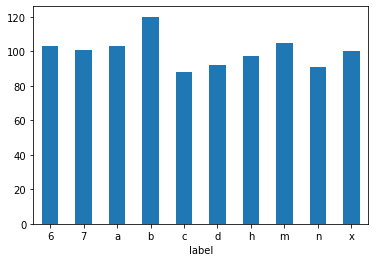

In [21]:
training.groupby("label")["label"].count().plot(kind="bar", rot=0)

In [79]:
def extract_features_and_labels(df):
    features = df.iloc[ : , training_data.columns.get_loc(0): ]
    labels = df.loc[ : , "label"]
    return(features, labels)

In [80]:
train, test = sklearn.model_selection.train_test_split(training_data,
                                                 test_size=800, 
                                                 random_state=seed )

x_train, y_train = extract_features_and_labels(train)
x_test, y_test = extract_features_and_labels(test)

In [118]:
# Encoding train
label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(np.concatenate((y_train, y_test), axis=0))
y_train_int = label_encoder.transform(y_train)
y_test_int = label_encoder.transform(y_test)
#one_hot_encoder = sklearn.preprocessing.OneHotEncoder(sparse=False)

In [70]:
# Using Linear Discriminant Analysis
lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(x_train, y_train_int)

In [156]:
# Training Accuracy
predicoes = lda.predict(x_train)
corretas = np.equal(predicoes, y_train_int)
erradas  = np.logical_not((corretas))

n_corretas = sum(corretas)
n_erradas = sum(erradas)

n_corretas/(n_corretas+n_erradas)

0.95

In [161]:
# Test Accuracy 
predicoes_lda = lda.predict(x_test)
corretas = np.equal(predicoes_lda, y_test_int)
erradas  = np.logical_not((corretas))

n_corretas = sum(corretas)
n_erradas = sum(erradas)

n_corretas/(n_corretas+n_erradas)

0.105

In [157]:
# Using naive bayes
nb  =  sklearn.naive_bayes.GaussianNB()
nb.fit(x_train, y_train_int)

GaussianNB(priors=None, var_smoothing=1e-09)

In [158]:
# Training Accuracy
predicoes = nb.predict(x_train)
corretas = np.equal(predicoes, y_train_int)
erradas  = np.logical_not((corretas))

n_corretas = sum(corretas)
n_erradas = sum(erradas)

n_corretas/(n_corretas+n_erradas)

0.51

In [160]:
# Test Accuracy 
predicoes_nb = nb.predict(x_test)
corretas = np.equal(predicoes_nb, y_test_int)
erradas  = np.logical_not((corretas))

n_corretas = sum(corretas)
n_erradas = sum(erradas)

n_corretas/(n_corretas+n_erradas)

0.0975

In [168]:
iguais = np.equal(predicoes_nb, predicoes_lda)
naives_corretas = np.equal(predicoes_nb, y_test_int)
iguais_corretas = np.logical_and(iguais, naives_corretas)